# SARCOS Dataset Problem 
----------------------------
Models applied to the SARCOS Dataset:  
Linear Regression  
K-NN  
RF  
Gaussian Process  


We also create a linear and sinusoidal toy problem to sense check the models.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

### Toy problem/data

In [2]:
#Toy 1D data set:
#Sinusoidal:
x_toy = np.linspace(-3,3,500)
y_sin = np.sin(x_toy)*0.5 +5 + np.random.normal(size = 500)*0.1 #Adding noise to the toy problem
#Linear:
y_lin = 2*x_toy + 5 + np.random.normal(size = 500)*0.1 #Adding noise to the toy problem

In [3]:
#Linear:
x_Toy, x_Toy_test, y_Toy, y_Toy_test = train_test_split(x_toy, y_lin, test_size=0.20, random_state=101)

#Sinusoidal:
xsin_Toy, xsin_Toy_test, ysin_Toy, ysin_Toy_test = train_test_split(x_toy, y_sin, test_size=0.20, random_state=101)

### Sarcos Data

In [4]:
sarcos = pd.read_csv('sarcos_inv.csv', header = None).values

In [5]:
xt_, xtst_, yt, ytst = train_test_split(sarcos[:,:-1], sarcos[:,-1], train_size=0.9, random_state=101)

In [6]:
xtst_ = xtst_[:50]
ytst = ytst[:50]

Here we standardize the x-values using the mean and unit standard deviation for each feature in the training data_set.

In [7]:
scaler = preprocessing.StandardScaler().fit(xt_)
xt, xtst = scaler.transform(xt_), scaler.transform(xtst_)

In [8]:
def calc_mse(Prediction, Y):
    mse = np.mean(np.square(Prediction - Y))
    return mse

# 1) Linear Regression  
## (using closed form solution)

Here we build the LinearRegression class. The Linear Regression is trained using the closed form solution:

$$ \hat{\beta} = (X^{T}X)^{-1}X^{T}y $$

In [9]:
class LinearRegression():
    
    def __init__(self, intercept = True):
        self.intercept = intercept
    
    def fit(self, X, Y):
        if self.intercept == True:
            if len(X.shape) == 1:
                X = X.reshape(-1,1)
                X = np.insert(X,0,1,1)
                w = (np.linalg.inv(X.T @ X)) @ X.T @ Y

                self.B = w[1:]
                self.c = w[0]
                
            else:
                X = np.insert(X,0,1,1)
                w = np.linalg.inv(X.T @ X) @ X.T @ Y

                self.B = w[1:]
                self.c = w[0]
        else:
            w = np.linalg.inv(X.T @ X) @ X.T @ Y
            self.B = w
            self.c = 0
        return self
            
    def predict(self, X_t):
        if len(X_t.shape) == 1:
            X_t = X_t.reshape(-1,1)
            Prediction = X_t @ self.B + self.c
        else:
            Prediction = X_t @ self.B + self.c
        
        return Prediction

### Sarcos LR

In [10]:
model = LinearRegression()
model.fit(xt,yt)
prediction = model.predict(xtst)

In [11]:
calc_mse(prediction,ytst)

16.766759879376508

### Toy Problem LR
Linear

In [12]:
model_toy_lin = LinearRegression()
model_toy_lin.fit(x_Toy,y_Toy)
prediction_toy_lin = model_toy_lin.predict(x_Toy_test)

In [13]:
calc_mse(prediction_toy_lin, y_Toy_test)

0.009980792922064287

Sinusoidal

In [14]:
model_toy_sin = LinearRegression()
model_toy_sin.fit(xsin_Toy,ysin_Toy)
prediction_toy_sin = model_toy_sin.predict(xsin_Toy_test)

In [15]:
calc_mse(prediction_toy_sin, ysin_Toy_test)

0.04394487279661109

### Plots for LR Toy Problem

#### Linear (with noise)

In [16]:
x_Toy_test_ = x_Toy_test[np.argsort(x_Toy_test)]
prediction_toy_lin_ = prediction_toy_lin[np.argsort(x_Toy_test)]
y_Toy_test_ = y_Toy_test[np.argsort(x_Toy_test)]

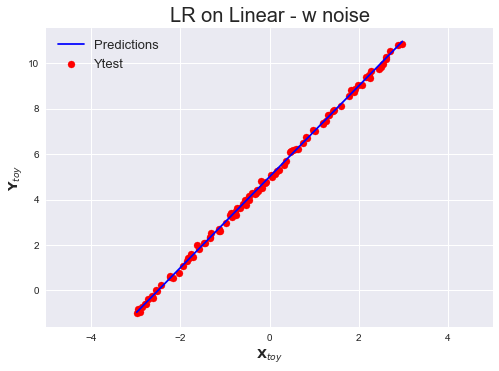

In [72]:
plt.style.use('seaborn')
plt.plot(x_Toy_test_, prediction_toy_lin_, color = 'b', label='Predictions')
plt.scatter(x_Toy_test_, y_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('LR on Linear - w noise', fontsize=20)
plt.xlim(-5,5)

plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)


plt.show()

#### Sinusoidal (with noise)

In [18]:
xsin_Toy_test_ = x_Toy_test[np.argsort(xsin_Toy_test)]
prediction_toy_sin_ = prediction_toy_sin[np.argsort(xsin_Toy_test)]
ysin_Toy_test_ = ysin_Toy_test[np.argsort(xsin_Toy_test)]

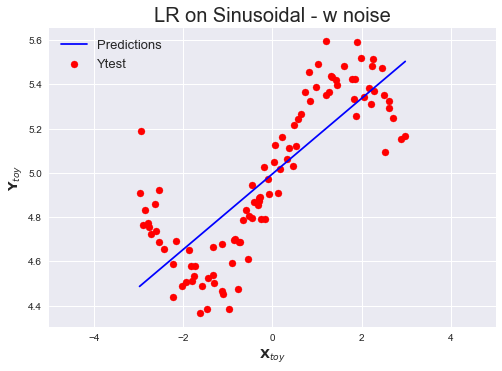

In [73]:
plt.style.use('seaborn')
plt.plot(xsin_Toy_test_, prediction_toy_sin_, color = 'b', label='Predictions')
plt.scatter(xsin_Toy_test_, ysin_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('LR on Sinusoidal - w noise', fontsize=20)
plt.xlim(-5,5)

plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)

plt.show()

# 2) K-NN

In [45]:
class KNN():

    def dist_matrix(self, X, Xt):
        if len(X.shape) == 1:
            X = X[:, None]
            Xt = Xt[:, None]
            
        euc_dist_ = 0
        for i in range(X.shape[-1]):
            euc_dist_ += np.square(X[:,i][None] - Xt[:,i][:,None])


        return np.sqrt(euc_dist_)
            
        
    def predict(self, dist_m, Y, K):
        NNs = np.argsort(dist_m)[:,:K]
        
        w_d = np.zeros((len(NNs),K))
        for i in range(len(NNs)):
            w_d[i,:] = dist_m[i,NNs[i]]
        
        denom = np.sum((1/w_d), axis=1)
        weighting = (1/w_d)/denom[:,None]
        
        predictions = np.sum((Y[NNs] * weighting), axis=1)
        
        return predictions
    

In [46]:
def Grid_Search(y_train, y_test, d_matrix, range_start, range_end):

    MSE_gridsearch = np.zeros((range_end - range_start))

    model_Grid_Srch = KNN()

    for K in tqdm(range(range_start,range_end)):

        predictions = model_Grid_Srch.predict(d_matrix, y_train, K)

        MSE_sarcos = calc_mse(predictions, y_test)

        MSE_gridsearch[K-1] = MSE_sarcos

    idx = np.argsort(MSE_gridsearch)[0]

    K = idx+1

    MSE_ = MSE_gridsearch[idx]

    return K, MSE_, MSE_gridsearch

### SARCOS K-NN

In [47]:
idx_k =round(0.6*xt.shape[0])
xt_k = xt[:idx_k]
yt_k = yt[:idx_k]

model_knn = KNN()
dist_matrix = model_knn.dist_matrix(xt_k,xtst)

In [48]:
k, mse, results = Grid_Search(yt_k, ytst, dist_matrix, 1, 21)

  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
(k,mse)

(9, 10.514521517529474)

### Toy Problem K-NN

Linear

In [66]:
model_knn_t_lin = KNN()
dist_matrix_toy_lin = model_knn_t_lin.dist_matrix(x_Toy, x_Toy_test)
k_toy_lin, mse_toy_lin, results_toy_lin = Grid_Search(y_Toy, y_Toy_test, dist_matrix_toy_lin, 1, 21)

  0%|          | 0/20 [00:00<?, ?it/s]

In [67]:
(k_toy_lin, mse_toy_lin)

(15, 0.010823710766638716)

Sinusoidal 

In [68]:
model_knn_t_sin = KNN()
dist_matrix_toy_sin = model_knn_t_sin.dist_matrix(xsin_Toy, xsin_Toy_test)
k_toy_sin, mse_toy_sin, results_toy_sin = Grid_Search(ysin_Toy, ysin_Toy_test, dist_matrix_toy_sin, 1, 21)

  0%|          | 0/20 [00:00<?, ?it/s]

In [69]:
(k_toy_sin, mse_toy_sin)

(11, 0.010047032238046181)

### Plots for KNN Toy Problem

#### Linear (with noise)

In [58]:
preds_knn_t_lin = model_knn_t_lin.predict(dist_matrix_toy_lin, y_Toy, k_toy_lin)
preds_knn_t_lin_ = preds_knn_t_lin[np.argsort(x_Toy_test)]

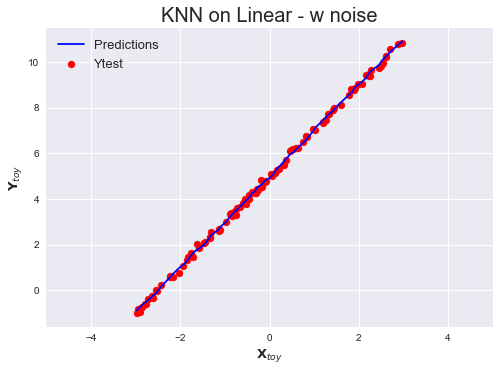

In [74]:
plt.style.use('seaborn')
plt.plot(x_Toy_test_, preds_knn_t_lin_, color = 'b', label='Predictions')
plt.scatter(x_Toy_test_, y_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('KNN on Linear - w noise', fontsize=20)
plt.xlim(-5,5)

plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)


plt.show()

#### Sinusoidal (with noise)

In [70]:
preds_knn_t_sin = model_knn_t_sin.predict(dist_matrix_toy_sin, ysin_Toy, k_toy_sin)
preds_knn_t_sin_ = preds_knn_t_sin[np.argsort(xsin_Toy_test)]

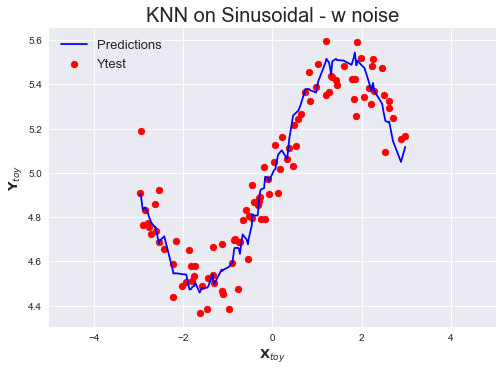

In [75]:
plt.style.use('seaborn')
plt.plot(xsin_Toy_test_, preds_knn_t_sin_, color = 'b', label='Predictions')
plt.scatter(xsin_Toy_test_, ysin_Toy_test_, color = 'r', label='Ytest')
plt.legend(prop={'size': 13})
plt.title('KNN on Sinusoidal - w noise', fontsize=20)
plt.xlim(-5,5)

plt.xlabel('$\mathbf{X}_{toy}$', size = 13)
plt.ylabel('$\mathbf{Y}_{toy}$', size = 13)

plt.show()